In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix
import glob
import cv2
import matplotlib.pyplot as plt
import seaborn as sns


In [1]:
IMAGE_SIZE = (90,90)  # Standard size for many CNN models

NUM_CLASSES = 16  # Update based on your specific dataset

def load_and_preprocess_images(image_paths, label_encoder=None):
    images = []
    labels = []
    
    for path in image_paths:
        # Extract label from path
        label = path.split(os.path.sep)[-2]
        
        # Read image
        img = cv2.imread(path)
        img = cv2.resize(img, IMAGE_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Normalize pixel values
        img = img / 255.0
        
        images.append(img)
        labels.append(label)
    
    # Encode labels
    if label_encoder is None:
        label_encoder = LabelEncoder()
        labels = label_encoder.fit_transform(labels)
    else:
        labels = label_encoder.transform(labels)
    
    return np.array(images), labels, label_encoder 

In [141]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_optimized_cnn(input_shape, num_classes, learning_rate):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Flatten(),
        Dense(100, activation='sigmoid'),
        Dropout(0.1),
        
        Dense(num_classes, activation='softmax')
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# Load image paths (modify according to your dataset structure)
train_image_paths = glob.glob('../datos/train/**/*.png', recursive=True)

# Preprocess training images
X_train, y_train, label_encoder = load_and_preprocess_images(train_image_paths)
print(f"Tamaño de X_train: {X_train.shape}, Tamaño de y_train: {len(y_train)}")

In [145]:
# Verifica que el número de muestras sea el mismo
print(f"Longitud de X_train: {len(X_train)}, Longitud de y_train: {len(y_train)}")

# Si son iguales, realiza la división
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


Longitud de X_train: 4324, Longitud de y_train: 4324


In [146]:
cnn_model = create_optimized_cnn(input_shape=(32, 32, 3), num_classes=len(label_encoder.classes_),learning_rate=0.00008)

history = cnn_model.fit(X_train, y_train, validation_data=(X_train, y_train), epochs=40, batch_size=16)

Epoch 1/40
217/217 [==============================] - 7s 28ms/step - loss: 2.7171 - accuracy: 0.1182 - val_loss: 2.6142 - val_accuracy: 0.1657
Epoch 2/40
217/217 [==============================] - 6s 27ms/step - loss: 2.5872 - accuracy: 0.1483 - val_loss: 2.5215 - val_accuracy: 0.1498
Epoch 3/40
217/217 [==============================] - 6s 26ms/step - loss: 2.5034 - accuracy: 0.1804 - val_loss: 2.4322 - val_accuracy: 0.2382
Epoch 4/40
217/217 [==============================] - 6s 26ms/step - loss: 2.4291 - accuracy: 0.2006 - val_loss: 2.3677 - val_accuracy: 0.2553
Epoch 5/40
217/217 [==============================] - 6s 26ms/step - loss: 2.3614 - accuracy: 0.2298 - val_loss: 2.3014 - val_accuracy: 0.2507
Epoch 6/40
217/217 [==============================] - 6s 27ms/step - loss: 2.3013 - accuracy: 0.2611 - val_loss: 2.2404 - val_accuracy: 0.3614
Epoch 7/40
217/217 [==============================] - 6s 27ms/step - loss: 2.2425 - accuracy: 0.2955 - val_loss: 2.1877 - val_accuracy: 0.3238

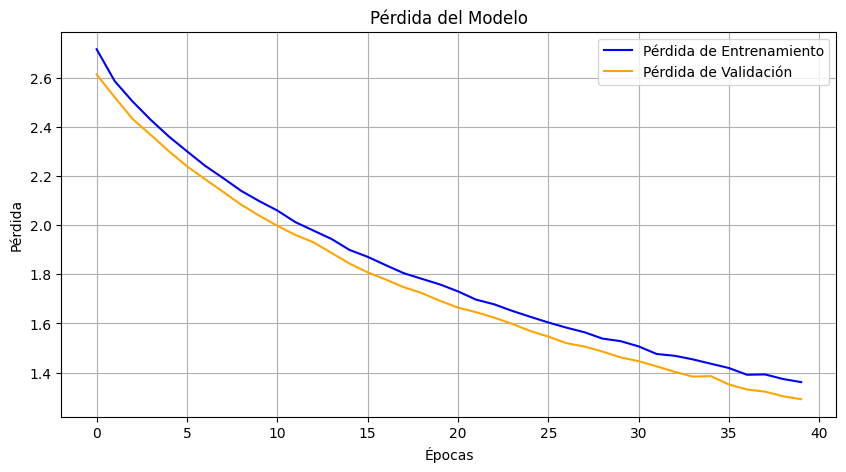

In [147]:
# Graficar la pérdida
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento', color='blue')
plt.plot(history.history['val_loss'], label='Pérdida de Validación', color='orange')
plt.title('Pérdida del Modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid()
plt.show()


In [149]:
# Evaluate CNN
cnn_val_loss, cnn_val_accuracy = cnn_model.evaluate(X_val, y_val)
print("CNN Validation Accuracy:", cnn_val_accuracy)

# Confusion Matrix for CNN
cnn_val_pred = cnn_model.predict(X_val)
cnn_val_pred_classes = np.argmax(cnn_val_pred, axis=1)

cnn_cm = confusion_matrix(y_val, cnn_val_pred_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cnn_cm, annot=True, fmt='d', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('cnn_confusion_matrix.png')
plt.close()
    
    

28/28 [==============================] - 0s 6ms/step - loss: 1.5272 - accuracy: 0.5133
CNN Validation Accuracy: 0.5132948160171509
28/28 [==============================] - 0s 6ms/step


In [ ]:
def prepare_submission(model, model_type, label_encoder):
    # Cargar rutas de imágenes de prueba
    test_image_paths = glob.glob('../datos/test/*.png')
    test_images, _, _ = load_and_preprocess_images(test_image_paths, None)  # Se pasa None en lugar del codificador de etiquetas

    # Predicción
    if model_type == 'lr':
        test_pred = model.predict(test_images.reshape(test_images.shape[0], -1))
    else:  # CNN
        test_pred = np.argmax(model.predict(test_images), axis=1)

    # Convertir predicciones al formato original de etiquetas
    test_pred_labels = label_encoder.inverse_transform(test_pred)

    # Crear el DataFrame de resultados
    submission_df = pd.DataFrame({
        'file': [os.path.basename(path) for path in test_image_paths],
        'species': test_pred_labels
    })

    # Guardar los resultados
    submission_df.to_csv(f'../resultados/{model_type}_submission.csv', index=False)
    print(f"Archivo de resultados guardado como: {model_type}_submission.csv")

# Llamada a la función para crear el archivo de resultados
prepare_submission(cnn_model, 'cnn', label_encoder)
